# Amplitude and width clustering

The blase model *should* overfit.  One common path for overfitting is to have lines with really large widths to make up for continuum imperfections.  Let's see if we can identify and flag these.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import seaborn as sns
sns.set_context('paper', font_scale=2)

In [2]:
from blase.emulator import PhoenixEmulator

Woohoo! You have a version 1.11.0.dev20211008 of PyTorch


In [3]:
! ls -t1 ../examples/*.pt

../examples/native_res_0p1prom.pt
../examples/model_coeffs.pt


In [4]:
! du -hs '../examples/native_res_0p1prom.pt'

80K	../examples/native_res_0p1prom.pt


In [67]:
with torch.no_grad():
    model_params = torch.load('../examples/native_res_0p1prom.pt')

In [6]:
emulator = PhoenixEmulator(4700, 4.5, prominence=0.1,)

In [7]:
emulator.load_state_dict(model_params)

<All keys matched successfully>

This step takes a *TON* of RAM unless you use `torch.no_grad`!

In [8]:
with torch.no_grad():
    cloned_spectrum = emulator.forward(emulator.wl_native)

In [9]:
type(cloned_spectrum), cloned_spectrum.shape

(torch.Tensor, torch.Size([338649]))

## $\pm 2.5\%$ residuals with a long tail

At native resolution

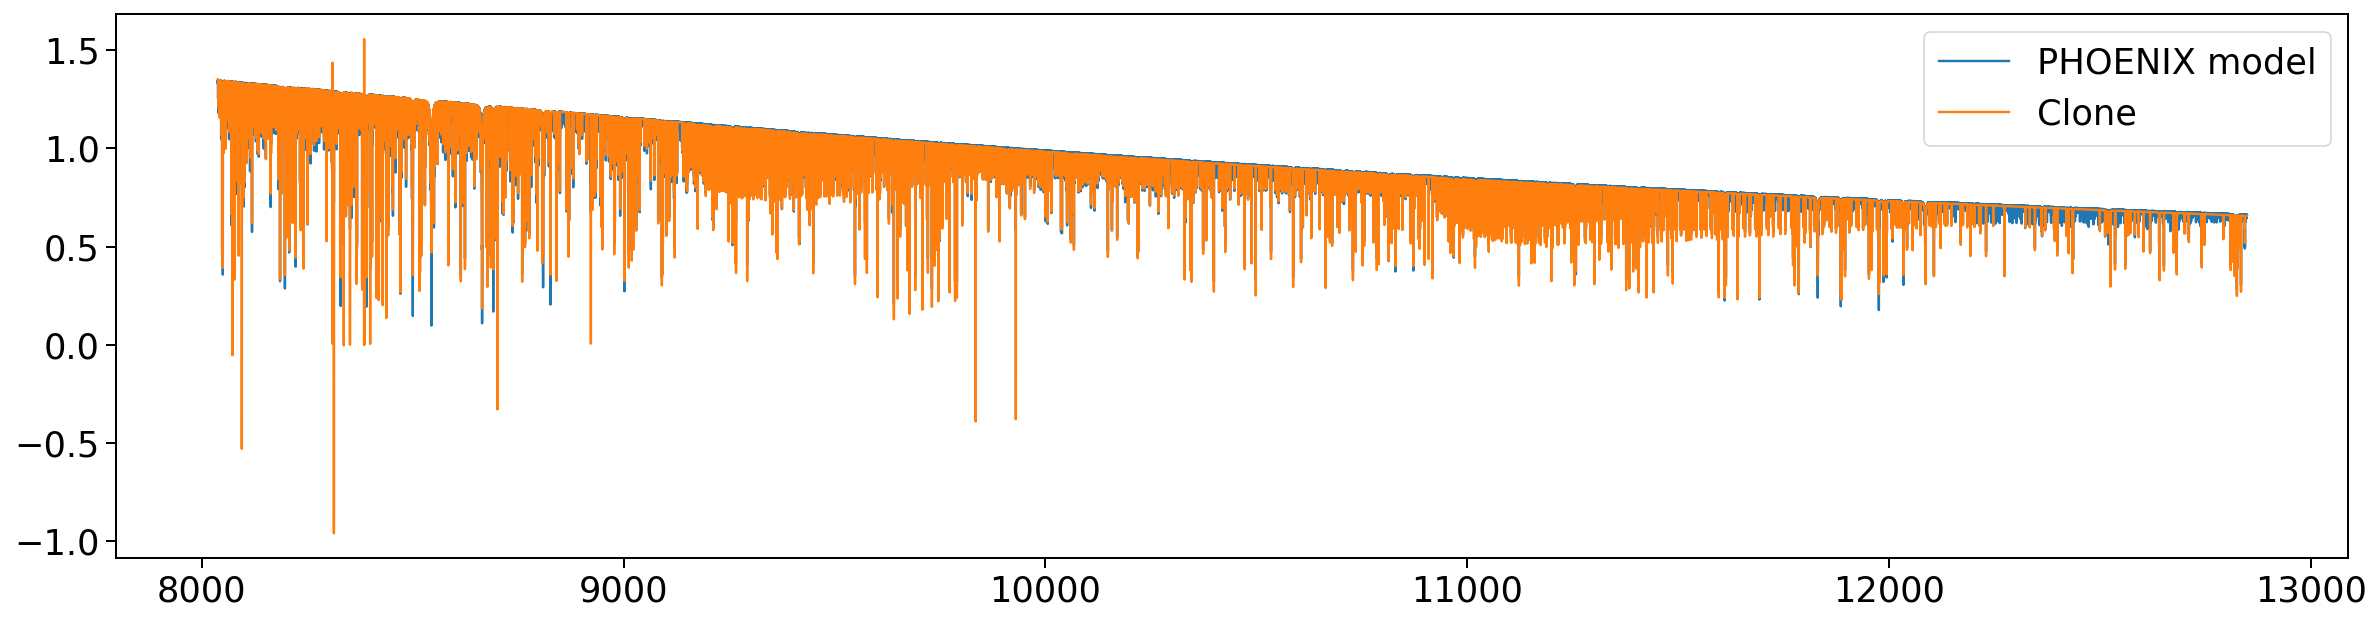

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(emulator.wl_native, emulator.flux_native, label='PHOENIX model')
plt.plot(emulator.wl_native, cloned_spectrum.detach(), label='Clone')
plt.legend()

In [11]:
residual = emulator.flux_native - cloned_spectrum.detach()

In [12]:
stddev = torch.std(residual)

Text(0, 0.5, 'Residual (%)')

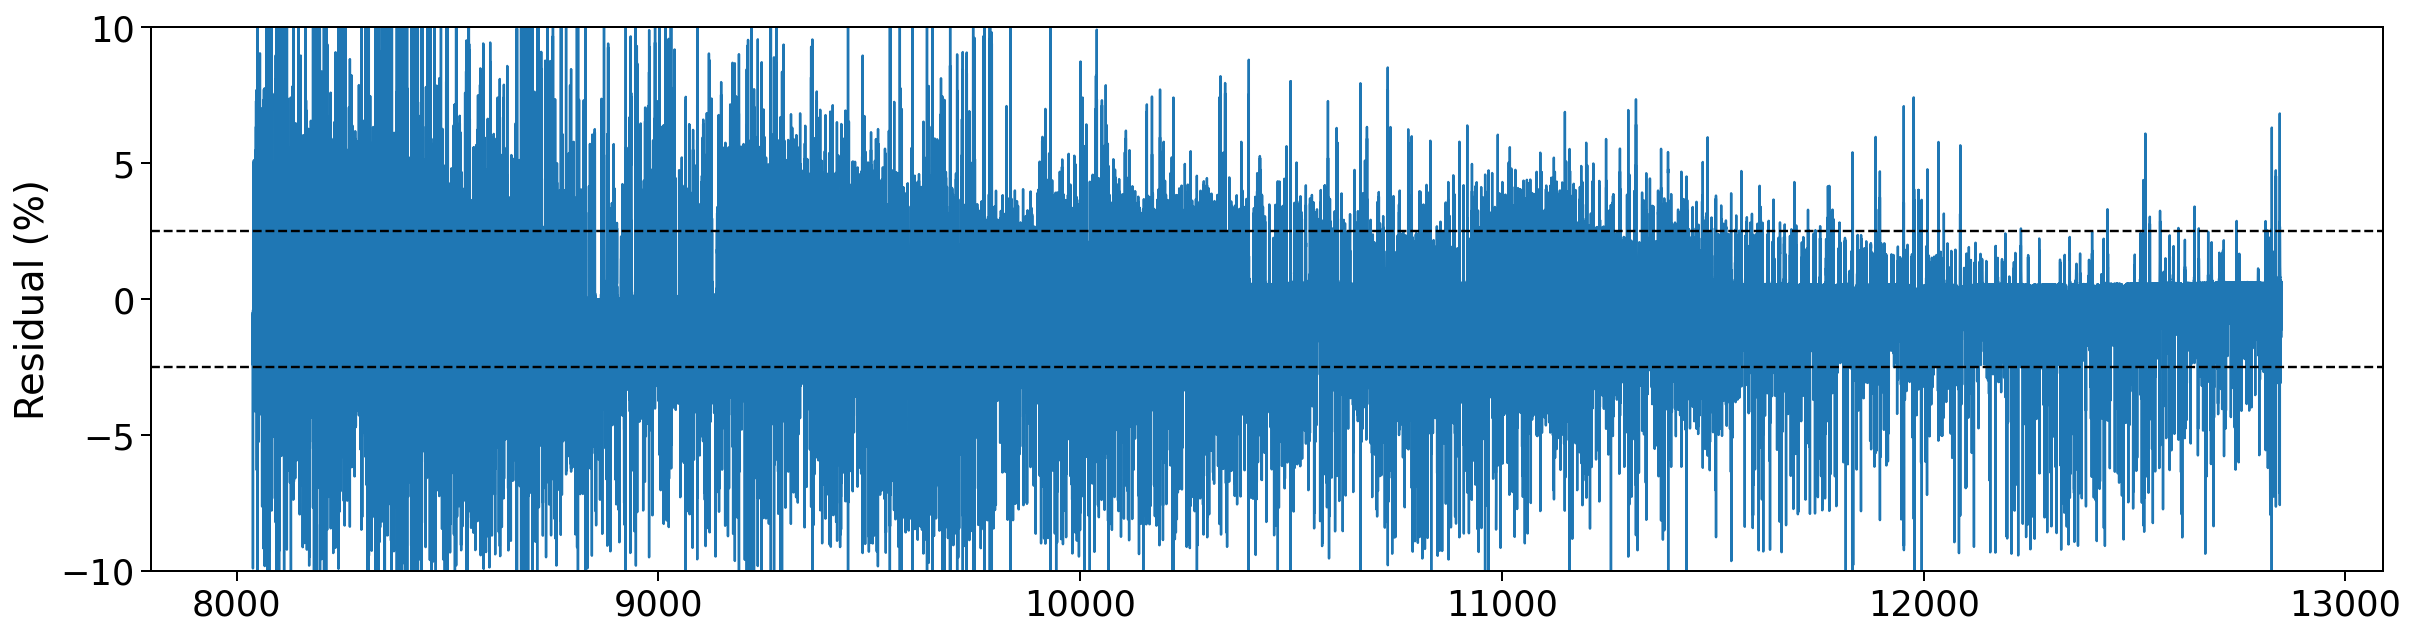

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(emulator.wl_native, residual*100.0, label='Residual')
plt.axhline(+stddev*100, color='k', linestyle='dashed')
plt.axhline(-stddev*100, color='k', linestyle='dashed')
plt.ylim(-10, 10)
plt.ylabel('Residual (%)')

Hmmm, those residuals seem large compared to the reported residuals after training... did something go wrong when we loaded them in?  Is there some hysteresis when loading a model?  A rounding error?

How big are the residuals when you smooth them to HPF resolution?

## Smooth to HPF resolution

In [22]:
from gollum.phoenix import PHOENIXSpectrum
import astropy.units as u

from muler.hpf import HPFSpectrumList

In [17]:
original_native = PHOENIXSpectrum(spectral_axis=emulator.wl_native*u.Angstrom, 
                                flux=emulator.flux_native*u.dimensionless_unscaled)

In [19]:
clone_native = PHOENIXSpectrum(spectral_axis=emulator.wl_native*u.Angstrom, 
                                flux=cloned_spectrum*u.dimensionless_unscaled)

In [23]:
echelle_orders = HPFSpectrumList.read('../../muler_example_data/HPF/01_A0V_standards/Goldilocks_20210517T054403_v1.0_0060.spectra.fits')

In [31]:
hpf_spectrum = echelle_orders.sky_subtract(method='vector')\
                                .deblaze()\
                                .normalize()\
                                .remove_nans()\
                                .trim_edges((6,2042))\
                                .stitch()

In [55]:
def simulate_observation(spectrum):
    """Simulate an observation with HPF"""
    return spectrum.rotationally_broaden(13.5)\
                    .rv_shift(-16.2)\
                    .instrumental_broaden(resolving_power=55_000)\
                    .resample(hpf_spectrum)

In [56]:
original_sim = simulate_observation(original_native)
clone_sim = simulate_observation(clone_native)

<AxesSubplot:xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

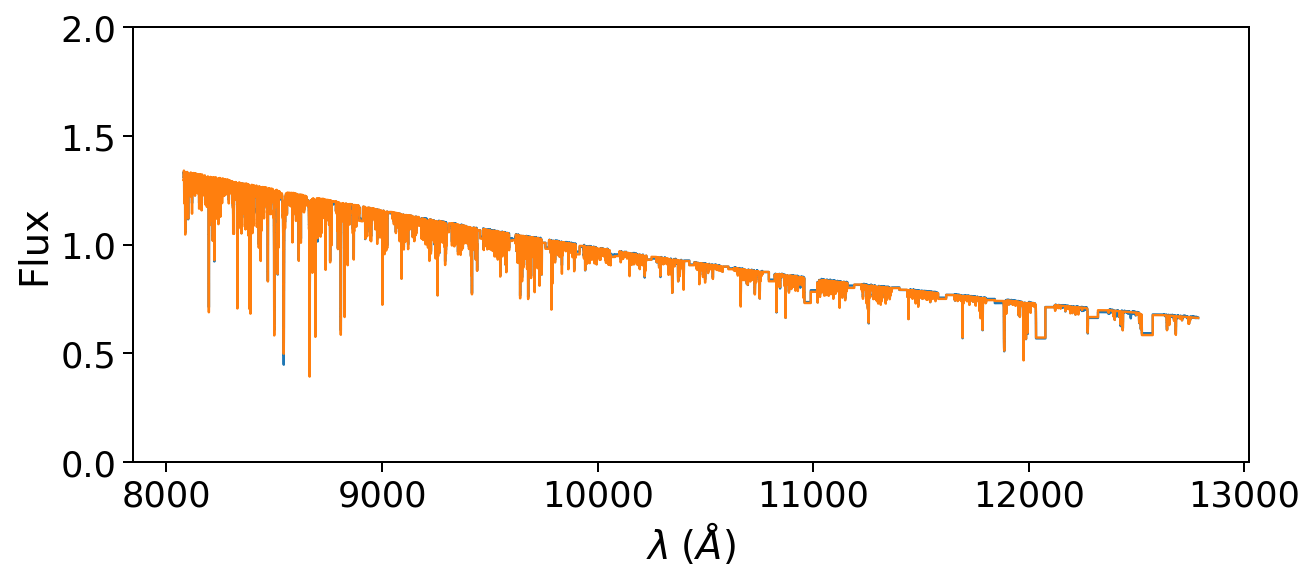

In [57]:
ax = original_sim.plot(ylo=0, yhi=2)
clone_sim.plot(ax=ax)

(10820.0, 10960.0)

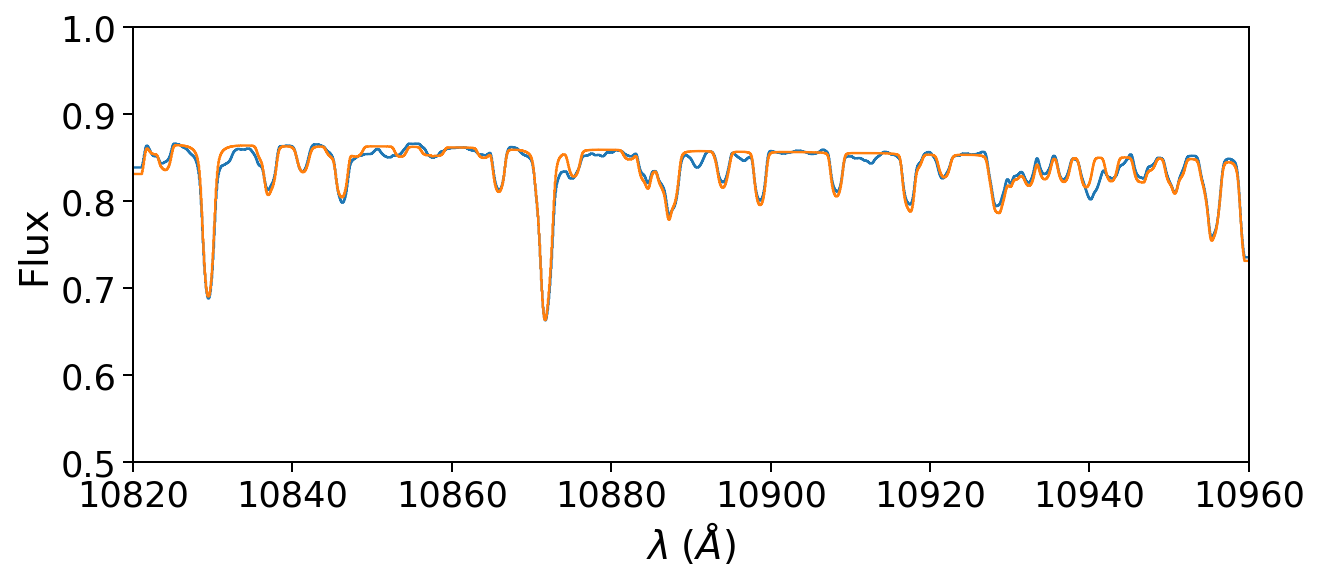

In [64]:
ax = original_sim.plot(ylo=0.5, yhi=1)
clone_sim.plot(ax=ax)
ax.set_xlim(10820, 10960)

Yuck!  The cloning is not adequate at this zoom level.  Did we not train long enough?

In [59]:
residual_spec = (original_sim - clone_sim)*100

In [60]:
stddev = residual_spec.flux.std().value

In [61]:
stddev

0.934881038332326

## $\pm 0.9\%$ residuals after smoothing and resampling


Text(0, 0.5, 'Residual (%)')

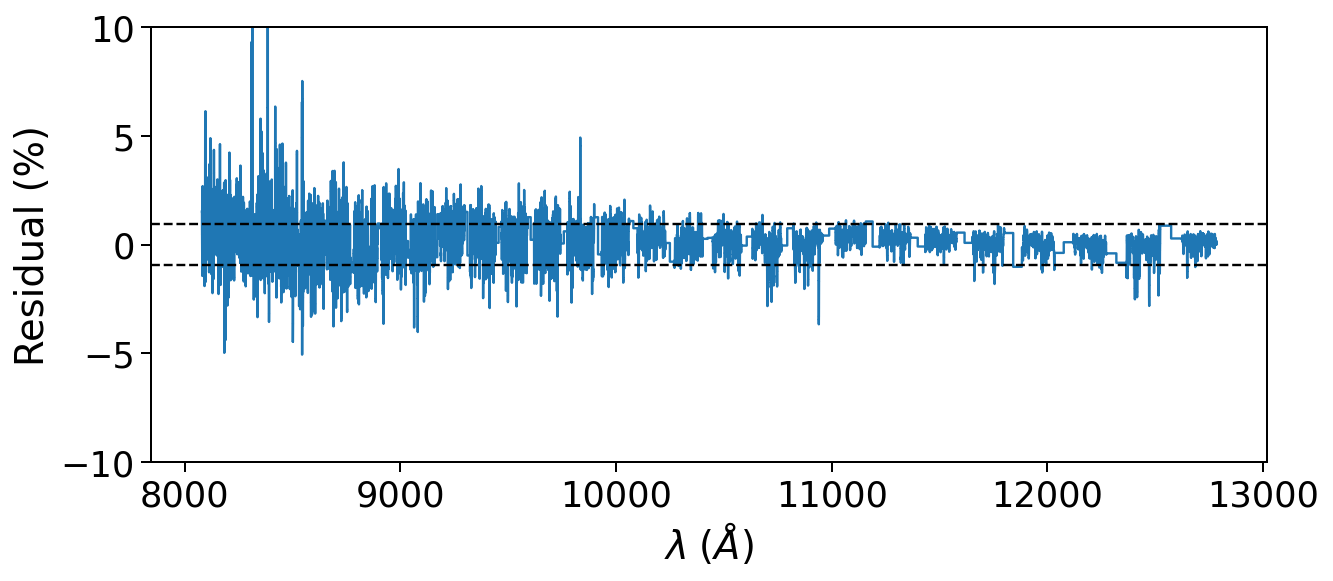

In [63]:
ax = residual_spec.plot(ylo=-10, yhi=10)
ax.axhline(+stddev, color='k', linestyle='dashed')
ax.axhline(-stddev, color='k', linestyle='dashed')
ax.set_ylabel('Residual (%)')

We still want better than 1%!  That level of residual is comparable to the SNR of a real spectrum.

## Clustering of parameters

In [72]:
amps, widths = model_params['amplitudes'].detach().cpu().numpy(), model_params['gamma_widths'].detach().cpu().numpy()

In [78]:
amps, widths = np.exp(amps), np.exp(widths)

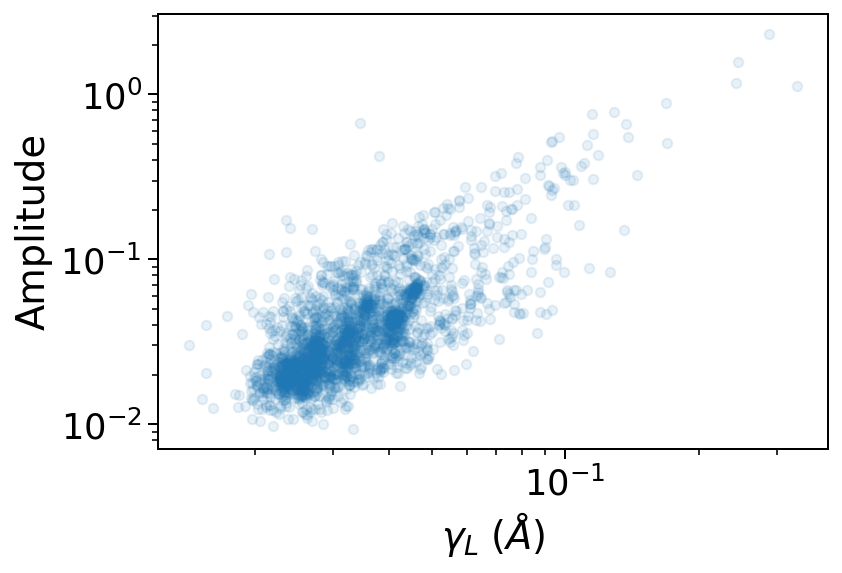

In [85]:
plt.plot(widths,amps, 'o', alpha=0.1)
plt.yscale('log'), plt.xscale('log')
plt.xlabel('$\gamma_L \; (\AA) $'); plt.ylabel('Amplitude');

Hmm, I'd expect to see continuum overfitting in the bottom right corner:  Wide lines with low amplitude.

In [87]:
from scipy.signal import find_peaks

In [90]:
biggest_residuals = find_peaks(np.abs(residual), height=0.1)

In [94]:
indices, meta_info = biggest_residuals

Text(0, 0.5, 'Residual (%)')

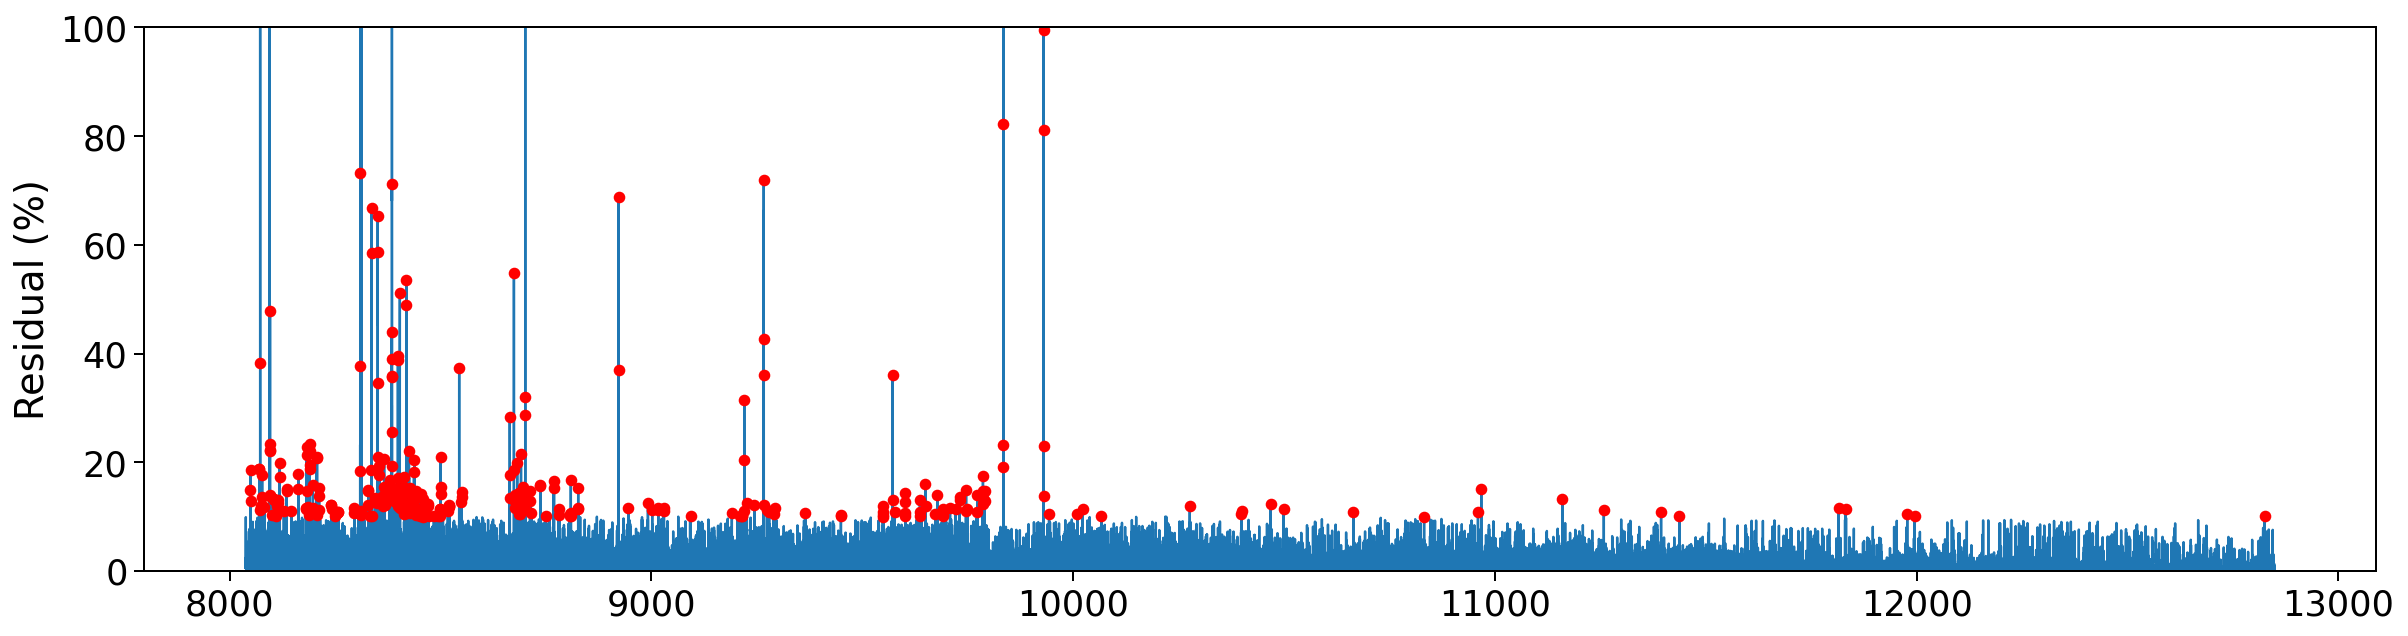

In [104]:
plt.figure(figsize=(20, 5))
plt.plot(emulator.wl_native, np.abs(residual*100.0), label='Residual')
plt.ylim(0, 100)

plt.plot(emulator.wl_native[indices], 100*meta_info['peak_heights'], 'ro')
plt.ylabel('Residual (%)')